# Neural Networks Project - Gesture Recognition
#### Institute: IIIT,Bangalore & upGrad
#### Course: PG Diploma in ML & AI (Batch: C 12)
#### Submission Date: 17-AUG-2020
#### Submitted By:
##### 1. Prannoy Prashad
##### 2. Anjali Sharma

# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [11]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [12]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [13]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
channels = 3
classes = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(1,30,2) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = int(np.floor(np.divide(len(t),batch_size)))# calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        leftover_batches = np.mod(len(t),batch_size)
        if leftover_batches !=0 :
            
            batch_data = np.zeros((leftover_batches,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((leftover_batches,5)) # batch_labels is the one hot representation of the output
            for folder in range(leftover_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*leftover_batches)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*leftover_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*leftover_batches)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Common methods to be used in models

### Defining common methods that can later be used for running multiple models. 

#### Optimise model method is used to initilaise the model with Adam Optimiser and a configutable learning rate. 

In [16]:
def optimiseModel(model,learning_rate):
    optimiser =  optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

#### Here we define train model where we checkpoint the model and save them in file after we use fit generator on model. 

In [17]:
def trainModel(model,modelName,batch_size,x,y,z):
    train_generator = generator(train_path, train_doc, batch_size,x,y,z)
    val_generator = generator(val_path, val_doc, batch_size,x,y,z)

    model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath =  model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    Generated_Model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, 
                      class_weight=None, workers=1, initial_epoch=0)
    return Generated_Model

#### This method is used to show the graph of model training accuracy vs validation  accuracy as well as training loss vs validation loss. 

In [18]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

## Model 1 : Conv3D + MaxPooling3D

#### This is the first model that we obtained after a lot of experiments. We have experimented with batch_size, epochs, learning rate, type of optimiser to be used. 


#### Experiment No. 1
Batch Size: 60

No. of image frames: 30

Image Height: 160

Image Width: 160

Learning Rate: 0.0001

Optimiser: Adam

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model_0 = Sequential()

model_0.add(Conv3D(8,  
                 kernel_size=(3,3,3), 
                 input_shape=(30,160,160,channels),
                 padding='same'))
model_0.add(BatchNormalization())
model_0.add(Activation('relu'))

model_0.add(MaxPooling3D(pool_size=(2,2,2)))

model_0.add(Conv3D(16,  
                 kernel_size=(3,3,3),
                 input_shape=(30,160,160,channels),
                 padding='same'))
model_0.add(BatchNormalization())
model_0.add(Activation('relu'))

model_0.add(MaxPooling3D(pool_size=(2,2,2)))

model_0.add(Conv3D(32,
                 kernel_size=(3,3,3),
                 input_shape=(30,160,160,channels),
                 padding='same'))
model_0.add(BatchNormalization())
model_0.add(Activation('relu'))

model_0.add(MaxPooling3D(pool_size=(2,2,2))),

model_0.add(Conv3D(64, 
                 kernel_size=(3,3,3),
                 input_shape=(30,160,160,channels),
                 padding='same'))
model_0.add(BatchNormalization())
model_0.add(Activation('relu'))

model_0.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_0.add(Flatten())

model_0.add(Dense(1000, activation='relu'))
model_0.add(Dropout(0.5))

model_0.add(Dense(500, activation='relu'))
model_0.add(Dropout(0.5))

#softmax layer
model_0.add(Dense(classes, activation='softmax'))

In [10]:
optimiseModel(model_0,0.0001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 16)    0         
__________

In [11]:
model_conv3D = trainModel(model_0,'model_init_conv3d',60,30,160,160)

Source path =  ./Project_data/val ; batch size = 60
Source path =  ./Project_data/trainEpoch 1/30
 ; batch size = 60


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/12 [==============================] - 67s 6s/step - loss: 2.6539 - categorical_accuracy: 0.2558 - val_loss: 1.4016 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00001-2.64378-0.27602-1.40158-0.39000.h5
Epoch 2/30
12/12 [==============================] - 46s 4s/step - loss: 1.9528 - categorical_accuracy: 0.3515 - val_loss: 1.2440 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00002-2.01464-0.35294-1.24401-0.43000.h5
Epoch 3/30
12/12 [==============================] - 49s 4s/step - loss: 1.8123 - categorical_accuracy: 0.3893 - val_loss: 1.1358 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00003-1.80235-0.39367-1.13581-0.56000.h5
Epoch 4/30
12/12 [==============================] - 49s 4s/step - loss: 1.5002 - categorical_accuracy: 0.4192 - val_loss: 1.3836 - val_categorical_accuracy:

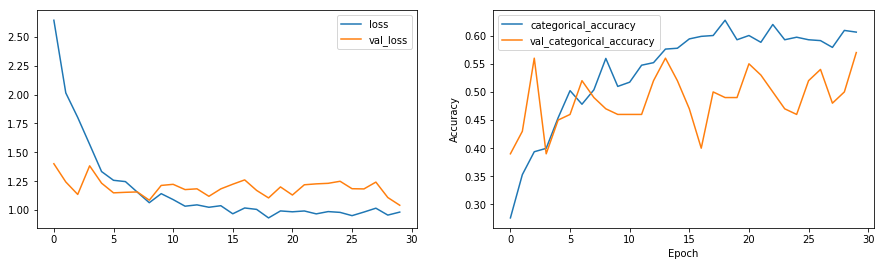

In [12]:
plot(model_conv3D )

Categorical Accuracy - 60% 

Validation Categorical Accuracy - 57%

Though the model is not overfitting but accuracy is very low. So we need to fine tune our model.

#### Experiment No. 2
Reusing the same model with different batch size.

Batch Size: 70

No. of image frames: 30

Image Height: 160

Image Width: 160

Learning Rate: 0.0001

Optimiser: Adam

In [14]:
model_conv3D = trainModel(model_0,'model_init_conv3d',70,30,160,160)

Source path =  ./Project_data/val ; batch size = 70
Source path =  ./Project_data/train ; batch size = 70
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ResourceExhaustedError: OOM when allocating tensor with shape[70,8,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/max_pooling3d_1/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_1/Relu, max_pooling3d_1/MaxPool3D, training/Adam/gradients/conv3d_2/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


OOM when allocating tensor with shape[70,8,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

We increased the batch size so that we can decrease the number of iterations in every epoch. But it resultes in OOM

#### Experiment No. 3

Batch Size: 60

No. of image frames: 30

Image Height: 120

Image Width: 120

Learning Rate: 0.0001

Optimiser: SGD

In [15]:
#write your model here
model_01 = Sequential()

model_01.add(Conv3D(8,  
                 kernel_size=(3,3,3), 
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_01.add(BatchNormalization())
model_01.add(Activation('relu'))

model_01.add(MaxPooling3D(pool_size=(2,2,2)))

model_01.add(Conv3D(16,  
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_01.add(BatchNormalization())
model_01.add(Activation('relu'))

model_01.add(MaxPooling3D(pool_size=(2,2,2)))

model_01.add(Conv3D(32,
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_01.add(BatchNormalization())
model_01.add(Activation('relu'))

model_01.add(MaxPooling3D(pool_size=(2,2,2))),

model_01.add(Conv3D(64, 
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_01.add(BatchNormalization())
model_01.add(Activation('relu'))

model_01.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_01.add(Flatten())

model_01.add(Dense(1000, activation='relu'))
model_01.add(Dropout(0.5))

model_01.add(Dense(500, activation='relu'))
model_01.add(Dropout(0.5))

#softmax layer
model_01.add(Dense(classes, activation='softmax'))

In [16]:
optimiser =  optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9)
model_01.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_01.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [17]:
model_conv3D1 = trainModel(model_01,'model_init_conv3d1',60,30,120,120)

Source path =  ./Project_data/val ; batch size = 60
Source path =  ./Project_data/train ; batch size = 60
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/12 [==============================] - 54s 5s/step - loss: 2.9088 - categorical_accuracy: 0.2640 - val_loss: 1.5781 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_conv3d1_2020-08-1713_11_56.028412/model-00001-3.08256-0.23228-1.57807-0.31000.h5
Epoch 2/30
12/12 [==============================] - 39s 3s/step - loss: 2.5523 - categorical_accuracy: 0.2369 - val_loss: 1.7953 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_conv3d1_2020-08-1713_11_56.028412/model-00002-2.65220-0.22926-1.79529-0.23000.h5
Epoch 3/30
12/12 [==============================] - 42s 3s/step - loss: 2.3251 - categorical_accuracy: 0.2209 - val_loss: 1.4447 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_conv3d1_2020-08-1713_11_56.028412/model-00003-2.36084-0.23831-1.44473-0.33000.h5
Epoch 4/30
12/12 [==============================] - 42s 4s/step - loss: 1.9665 - categorical_accuracy: 0.2802 - val_loss: 1.3556 - val_categorical_accura

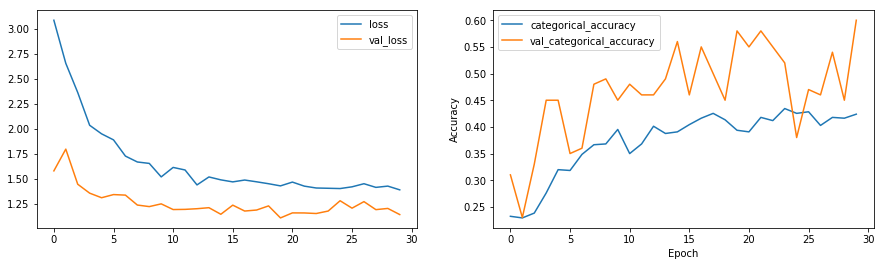

In [18]:
plot(model_conv3D1 )

Categorical Accuracy - 41% 

Validation Categorical Accuracy - 60%

We experimented with the optimiser. Instead of Adam optimiser, we used SGD optimiser but our accuracy further dropped. So we will switch back to Adam

#### Experiment No. 4

Batch Size: 50

No. of image frames: 30

Image Height: 100

Image Width: 100

Learning Rate: 0.001

Optimiser: Adam

In [22]:
#write your model here
model_02 = Sequential()

model_02.add(Conv3D(8,  
                 kernel_size=(3,3,3), 
                 input_shape=(30,100,100,channels),
                 padding='same'))
model_02.add(BatchNormalization())
model_02.add(Activation('relu'))

model_02.add(MaxPooling3D(pool_size=(2,2,2)))

model_02.add(Conv3D(16,  
                 kernel_size=(3,3,3),
                 input_shape=(30,100,100,channels),
                 padding='same'))
model_02.add(BatchNormalization())
model_02.add(Activation('relu'))

model_02.add(MaxPooling3D(pool_size=(2,2,2)))

model_02.add(Conv3D(32,
                 kernel_size=(3,3,3),
                 input_shape=(30,100,100,channels),
                 padding='same'))
model_02.add(BatchNormalization())
model_02.add(Activation('relu'))

model_02.add(MaxPooling3D(pool_size=(2,2,2))),

model_02.add(Conv3D(64, 
                 kernel_size=(3,3,3),
                 input_shape=(30,100,100,channels),
                 padding='same'))
model_02.add(BatchNormalization())
model_02.add(Activation('relu'))

model_02.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_02.add(Flatten())

model_02.add(Dense(1000, activation='relu'))
model_02.add(Dropout(0.5))

model_02.add(Dense(500, activation='relu'))
model_02.add(Dropout(0.5))

#softmax layer
model_02.add(Dense(classes, activation='softmax'))

In [23]:
optimiseModel(model_02,0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 100, 100, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 30, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 50, 50, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 50, 50, 16)    64        
_________________________________________________________________
activation_14 (Activation)   (None, 15, 50, 50, 16)    0         
__________

In [24]:
model_conv3D2 = trainModel(model_02,'model_init_conv3d2',50,30,100,100)

Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/train ; batch size = 50
Epoch 1/30
 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 7s - loss: 3.2601 - categorical_accuracy: 0.2850 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 49s 4s/step - loss: 3.0851 - categorical_accuracy: 0.2734 - val_loss: 4.0743 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_conv3d2_2020-08-1713_11_56.028412/model-00001-3.12300-0.28356-4.07429-0.24000.h5
Epoch 2/30
14/14 [==============================] - 38s 3s/step - loss: 1.5478 - categorical_accuracy: 0.3545 - val_loss: 2.2649 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_conv3d2_2020-08-1713_11_56.028412/model-00002-1.54347-0.35294-2.26486-0.27000.h5
Epoch 3/30
14/14 [==============================] - 41s 3s/step - loss: 1.4120 - categorical_accuracy: 0.3618 - val_loss: 1.5370 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to model_init_conv3d2_2020-08-1713_11_56.028412/model-00003-1.37810-0.37255-1.53703-0.31000.h5
Epoch 4/30
14/14 [==============================] - 40s 3s/step - loss: 1.2666 - categorical_accuracy: 0.4023 - val_loss: 1.5182 - val_categorical_accura

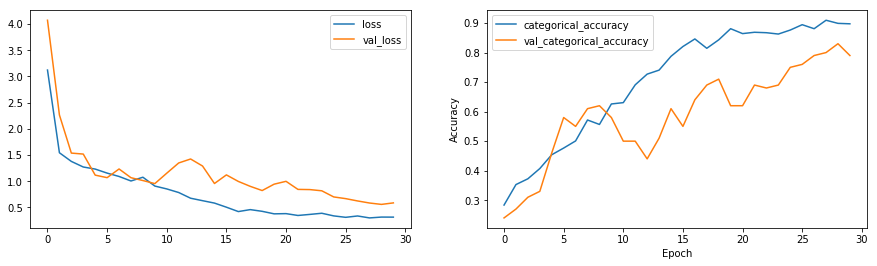

In [26]:
plot(model_conv3D2 )

Categorical Accuracy - 90% 

Validation Categorical Accuracy - 83%

This model is quite acceptable as the accuracy has increased signifcantly after reducing the image dimensions. 

#### Experiment No. 5

Batch Size: 50

No. of image frames: 30

Image Height: 120

Image Width: 120

Learning Rate: 0.001

Optimiser: Adam

In [27]:

#write your model here
model_1 = Sequential()

model_1.add(Conv3D(8,  
                 kernel_size=(3,3,3), 
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(16,  
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(32,
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2))),

model_1.add(Conv3D(64, 
                 kernel_size=(3,3,3),
                 input_shape=(30,120,120,channels),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_1.add(Flatten())

model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(500, activation='relu'))
model_1.add(Dropout(0.5))

#softmax layer
model_1.add(Dense(classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [28]:
optimiseModel(model_1,0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_17 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_18 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [29]:
model_conv3D = trainModel(model_1,'model_init_conv3d',50,30,120,120)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 7s - loss: 4.5369 - categorical_accuracy: 0.2533 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 53s 4s/step - loss: 4.1780 - categorical_accuracy: 0.2609 - val_loss: 2.9036 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00001-4.29667-0.26244-2.90359-0.32000.h5
Epoch 2/30
14/14 [==============================] - 39s 3s/step - loss: 1.6673 - categorical_accuracy: 0.3015 - val_loss: 2.2332 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00002-1.65368-0.30920-2.23318-0.23000.h5
Epoch 3/30
14/14 [==============================] - 42s 3s/step - loss: 1.3493 - categorical_accuracy: 0.4038 - val_loss: 1.6568 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_conv3d_2020-08-1713_11_56.028412/model-00003-1.35501-0.40875-1.65679-0.32000.h5
Epoch 4/30
14/14 [==============================] - 42s 3s/step - loss: 1.2212 - categorical_accuracy: 0.4567 - val_loss: 1.2454 - val_categorical_accuracy:

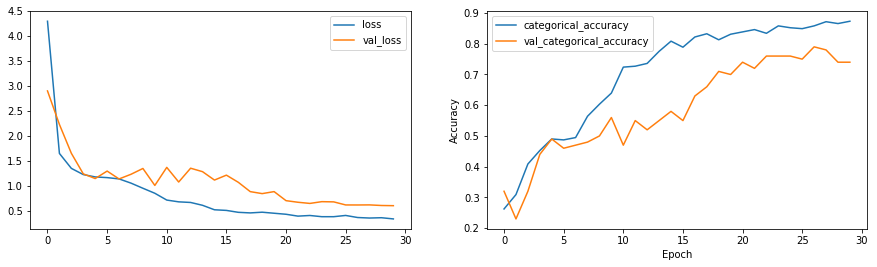

In [30]:
plot(model_conv3D )

Categorical Accuracy - 87% 

Validation Categorical Accuracy - 79%

Though the categorical accuracy has increased but validation accuracy has reduced. So we need to experiment more

### Conclusion of experiments : 
#### 1. We observed that increasing the number of epochs led to an increase in the model accuracy. 
#### 2. Adding dropouts after convolutions also helped in increasing the accuracy and preventng the model from overfitting. 
#### 3. We tried mulitple optimisers and concluded that Adam optimiser worked best for us. 
#### 4. We also tried various learning rates and 0.001 along wth reduceLROnPlateau callback from keras wprked best for this model. 
#### 5. We also tried various kernel sizes and number of filters used to every layer. We observed that on increasing the number of layers, the model was taking a longer time to train with a significant increase in no. of trainable parameters and not so much increase in accuracy. This is how we chose the number of layers for our final model. 
#### 6. We also tried using differet image indexes in the generator function and figured that using all 30 images were taking a ot of time to train with no such increase in accuracy. 

## Model 2 : 2D Conv + RNN (Transfer Learning using MobileNet and LSTM)

In [20]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [21]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_2 = Sequential()
model_2.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,channels)))


for layer in model_2.layers:
    layer.trainable = False


model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

model_2.add(LSTM(64))
model_2.add(Dropout(0.25))

model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(classes, activation='softmax'))

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [22]:
optimiseModel(model_2,0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
__________

In [23]:
model_RNN = trainModel(model_2,'model_init_RNN',50,30,120,120)

Source path =  ./Project_data/val ; batch size = 50
Source path = Epoch 1/30 ./Project_data/train ; batch size = 50



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 19s - loss: 1.6414 - categorical_accuracy: 0.1983

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 132s 9s/step - loss: 1.6336 - categorical_accuracy: 0.2073 - val_loss: 1.6540 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_RNN_2020-08-1716_59_30.277997/model-00001-1.63863-0.20211-1.65401-0.18000.h5
Epoch 2/30
14/14 [==============================] - 42s 3s/step - loss: 1.6234 - categorical_accuracy: 0.2245 - val_loss: 1.6786 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_RNN_2020-08-1716_59_30.277997/model-00002-1.61877-0.22021-1.67864-0.18000.h5
Epoch 3/30
14/14 [==============================] - 42s 3s/step - loss: 1.5971 - categorical_accuracy: 0.2475 - val_loss: 1.6428 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_RNN_2020-08-1716_59_30.277997/model-00003-1.59851-0.24434-1.64278-0.18000.h5
Epoch 4/30
14/14 [==============================] - 42s 3s/step - loss: 1.5813 - categorical_accuracy: 0.2557 - val_loss: 1.6191 - val_categorical_accuracy: 0.2900


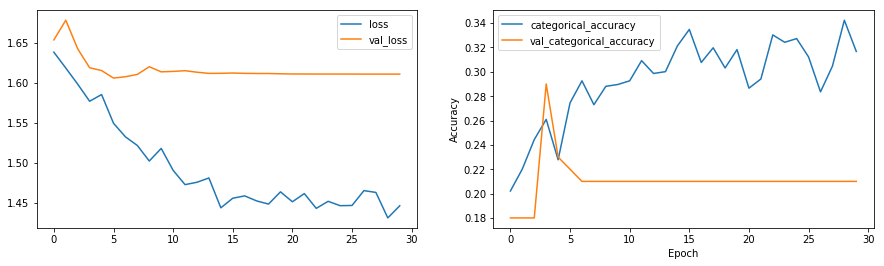

In [24]:
plot(model_RNN)

In [25]:
#mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_3 = Sequential()
model_3.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,channels)))


for layer in model_3.layers:
    layer.trainable = False


model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_3.add(TimeDistributed(Flatten()))

model_3.add(GRU(64))
model_3.add(Dropout(0.25))

model_3.add(Dense(64,activation='relu'))
model_3.add(Dropout(0.25))

model_3.add(Dense(classes, activation='softmax'))

In [26]:
optimiseModel(model_3,0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [27]:
model_GRU = trainModel(model_3,'model_init_GRU',50,30,120,120)

Source path = Source path =  ./Project_data/train ; batch size = 50
 ./Project_data/val ; batch size = 50
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 7s - loss: 1.8997 - categorical_accuracy: 0.1800 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 53s 4s/step - loss: 1.8832 - categorical_accuracy: 0.1797 - val_loss: 1.6454 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_GRU_2020-08-1716_59_30.277997/model-00001-1.88746-0.18100-1.64541-0.21000.h5
Epoch 2/30
14/14 [==============================] - 40s 3s/step - loss: 1.6547 - categorical_accuracy: 0.2551 - val_loss: 1.6643 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_GRU_2020-08-1716_59_30.277997/model-00002-1.64594-0.25641-1.66431-0.21000.h5
Epoch 3/30
14/14 [==============================] - 43s 3s/step - loss: 1.6085 - categorical_accuracy: 0.2753 - val_loss: 1.6451 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_GRU_2020-08-1716_59_30.277997/model-00003-1.58358-0.28959-1.64509-0.21000.h5
Epoch 4/30
14/14 [==============================] - 42s 3s/step - loss: 1.4907 - categorical_accuracy: 0.3607 - val_loss: 1.6788 - val_categorical_accuracy: 0.2100



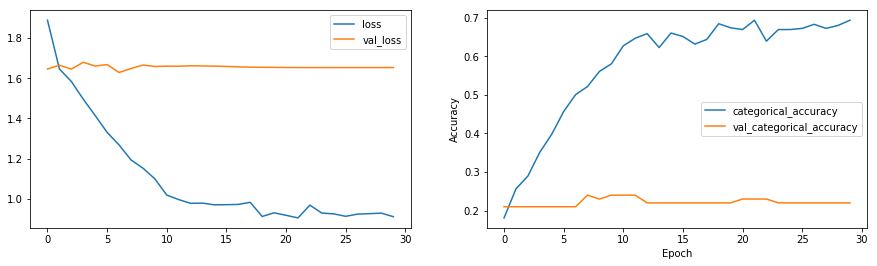

In [28]:
plot(model_GRU)

### Conclusion: 
#### 1. Though LSTM has reduced no. of trainable parameters but its performing very poorly.
#### 2. Though GRU is performing better than LSTM but the model is clearly over fitting.  

## Consolidated Final Model

Final Model: The best model according to our analysis is Conv3D+ MaxPooling3D where the hyper-parameters are

Batch Size: 50

No. of image frames: 30

Image Height: 100

Image Width: 100

Learning Rate: 0.001

Optimiser: Adam

Here, we got the training accuracy as approx. 90% and validation accuracy as 83% where total number of trainable parameters are 28,81,589.

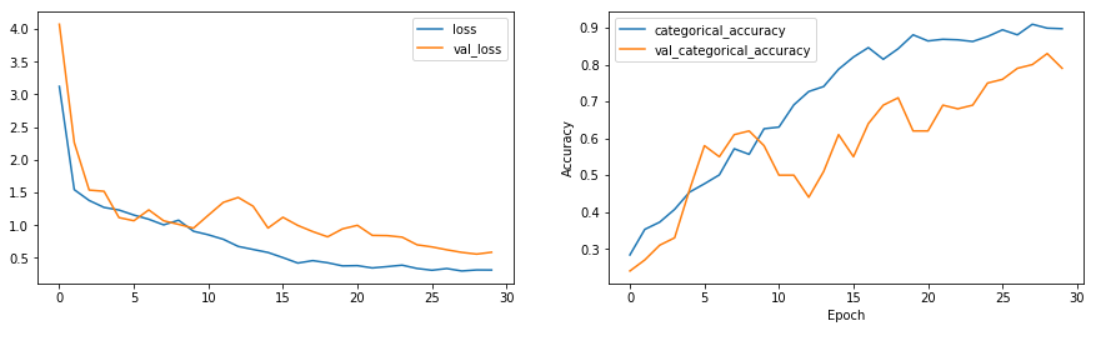
